# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm-research/ttm-research-r2)

## Install `tsfm` 
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

In [1]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.14"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.14) to /tmp/pip-install-0ayck_hf/tsfm-public_83ee417ee36f4934bc146989e2080156
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-0ayck_hf/tsfm-public_83ee417ee36f4934bc146989e2080156
  Running command git checkout -q fea9e7e578065d38491f777422a43cea71564994
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit fea9e7e578065d38491f777422a43cea71564994
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tsfm_public: filename=tsfm_public-0.2.14-py3-none-any.whl size=2334084 sha256=e1fd0dc70ad6b40f0487d5f98ba586a5eb61a11706a30c57ccff2aa3e1a047bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-0w2fjmbp/wheels/b8/6a/d5/2b6181df2b76fad37671c21f8979cc34fc33a534eedaf1d439
Successfully built tsfm_public
DEPRECATION: xgbse 0.2.3 has a n

## Imports

In [1]:
import math
import os

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder

/dccstor/tsfm-irl/conda_envs/envs/tsfmhf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-07 23:37:33.100029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def plot_preds(trainer, dset, plot_dir, num_plots=10, plot_prefix="valid", channel=-1, truncate_history=True, indices = None):
    device = torch.cuda.current_device() if torch.cuda.is_available() else torch.device("cpu")
    if indices == None:
        random_indices = np.random.choice(len(dset), size=num_plots, replace=False)
    else:
        random_indices = indices
    random_samples = torch.stack([dset[i]["past_values"] for i in random_indices])
    trainer.model = trainer.model.to(device)
    output = trainer.model(random_samples.to(device=device))
    y_hat = output.prediction_outputs[:, :, :, channel].detach().cpu().numpy()
    pred_len = y_hat.shape[2]
    num_quantiles = y_hat.shape[1]

    # Set a more beautiful style
    plt.style.use("seaborn-v0_8-whitegrid")

    # Adjust figure size and subplot spacing
    fig, axs = plt.subplots(num_plots, 1, figsize=(30, 60))
    for i, ri in enumerate(random_indices):
        batch = dset[ri]

        y = batch["future_values"][:pred_len, channel].squeeze().cpu().numpy()
        if truncate_history:
            x = batch["past_values"][-2 * pred_len :, channel].squeeze().cpu().numpy()
        else:
            x = batch["past_values"][:, channel].squeeze().cpu().numpy()
        y = np.concatenate((x, y), axis=0)

        # Plot predicted values with a dashed line

        for q in range(num_quantiles):
            y_hat_plot = np.concatenate((x, y_hat[i, q, ...]), axis=0)
            axs[i].plot(y_hat_plot, label="Predicted_" + str(q), linestyle="--", linewidth=2)
            
        # Plot true values with a solid line
        axs[i].plot(y, label="True", linestyle="-", color="blue", linewidth=2)

        # Plot horizon border
        axs[i].axvline(x=2 * pred_len, color="r", linestyle="-")

        axs[i].set_title(f"Example {random_indices[i]}")
        axs[i].legend()

    # Adjust overall layout
    plt.tight_layout()

    # Save the plot
    plot_filename = f"synthetic_{plot_prefix}_ch_{str(channel)}.pdf"
    os.makedirs(plot_dir, exist_ok=True)
    plt.savefig(os.path.join(plot_dir, plot_filename))

### Important arguments

In [4]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Data processing

In [5]:
# Dataset
TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 8640],
    "valid": [8640, 11520],
    "test": [
        11520,
        14400,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

 ## Few-shot finetune and evaluation method

In [6]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    quantile=0.5,
    loss = "mse",
    multi_quantile_heads=None,
    multi_quantile_head_weights=None,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    dset_train, dset_val, dset_test = get_datasets(
        tsp, data, split_config, fewshot_fraction=fewshot_percent / 100, fewshot_location="first"
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            head_dropout=0.7,
            quantile=quantile,
            loss = loss,
            multi_quantile_heads=multi_quantile_heads,
            multi_quantile_head_weights=multi_quantile_head_weights,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            quantile=quantile,
            loss = loss,
            multi_quantile_heads=multi_quantile_heads,
            multi_quantile_head_weights=multi_quantile_head_weights,
        )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_preds(
        trainer=finetune_forecast_trainer,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

    return predictions_dict

### Few-shot 5%

INFO:p-2836057:t-23013474849536:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-2836057:t-23013474849536:get_model.py:get_model:Selected TTM `prediction_length` = 96


-------------------- Running few-shot 5% --------------------


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['head.quantile_heads.quantile_embeddings']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:p-2836057:t-23013474849536:get_model.py:get_model:Model loaded successfully!
INFO:p-2836057:t-23013474849536:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 96
INFO:p-2836057:t-23013474849536:lr_finder.py:optimal_lr_finder:LR Finder: Running learning rate (LR) finder algorithm. If the suggested LR is very low, we suggest setting the LR manually.
INFO:p-2836057:t-23013474849536:lr_finder.py:optimal_lr_finder:LR Finder: Using CPU.


Number of params before freezing backbone 805760
Number of params after freezing the backbone 290176


INFO:p-2836057:t-23013474849536:lr_finder.py:optimal_lr_finder:LR Finder: Suggested learning rate = 0.000756463327554629


OPTIMAL SUGGESTED LEARNING RATE = 0.000756463327554629
Using learning rate = 0.000756463327554629


Epoch,Training Loss,Validation Loss
1,0.327900,0.273253


[TrackingCallback] Mean Epoch Time = 1.572178602218628 seconds, Total Train Time = 6.539901971817017
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.19427409768104553, 'eval_runtime': 5.3864, 'eval_samples_per_second': 517.048, 'eval_steps_per_second': 8.169, 'epoch': 1.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2785, 5, 96, 7)
(2785, 7, 8, 192)


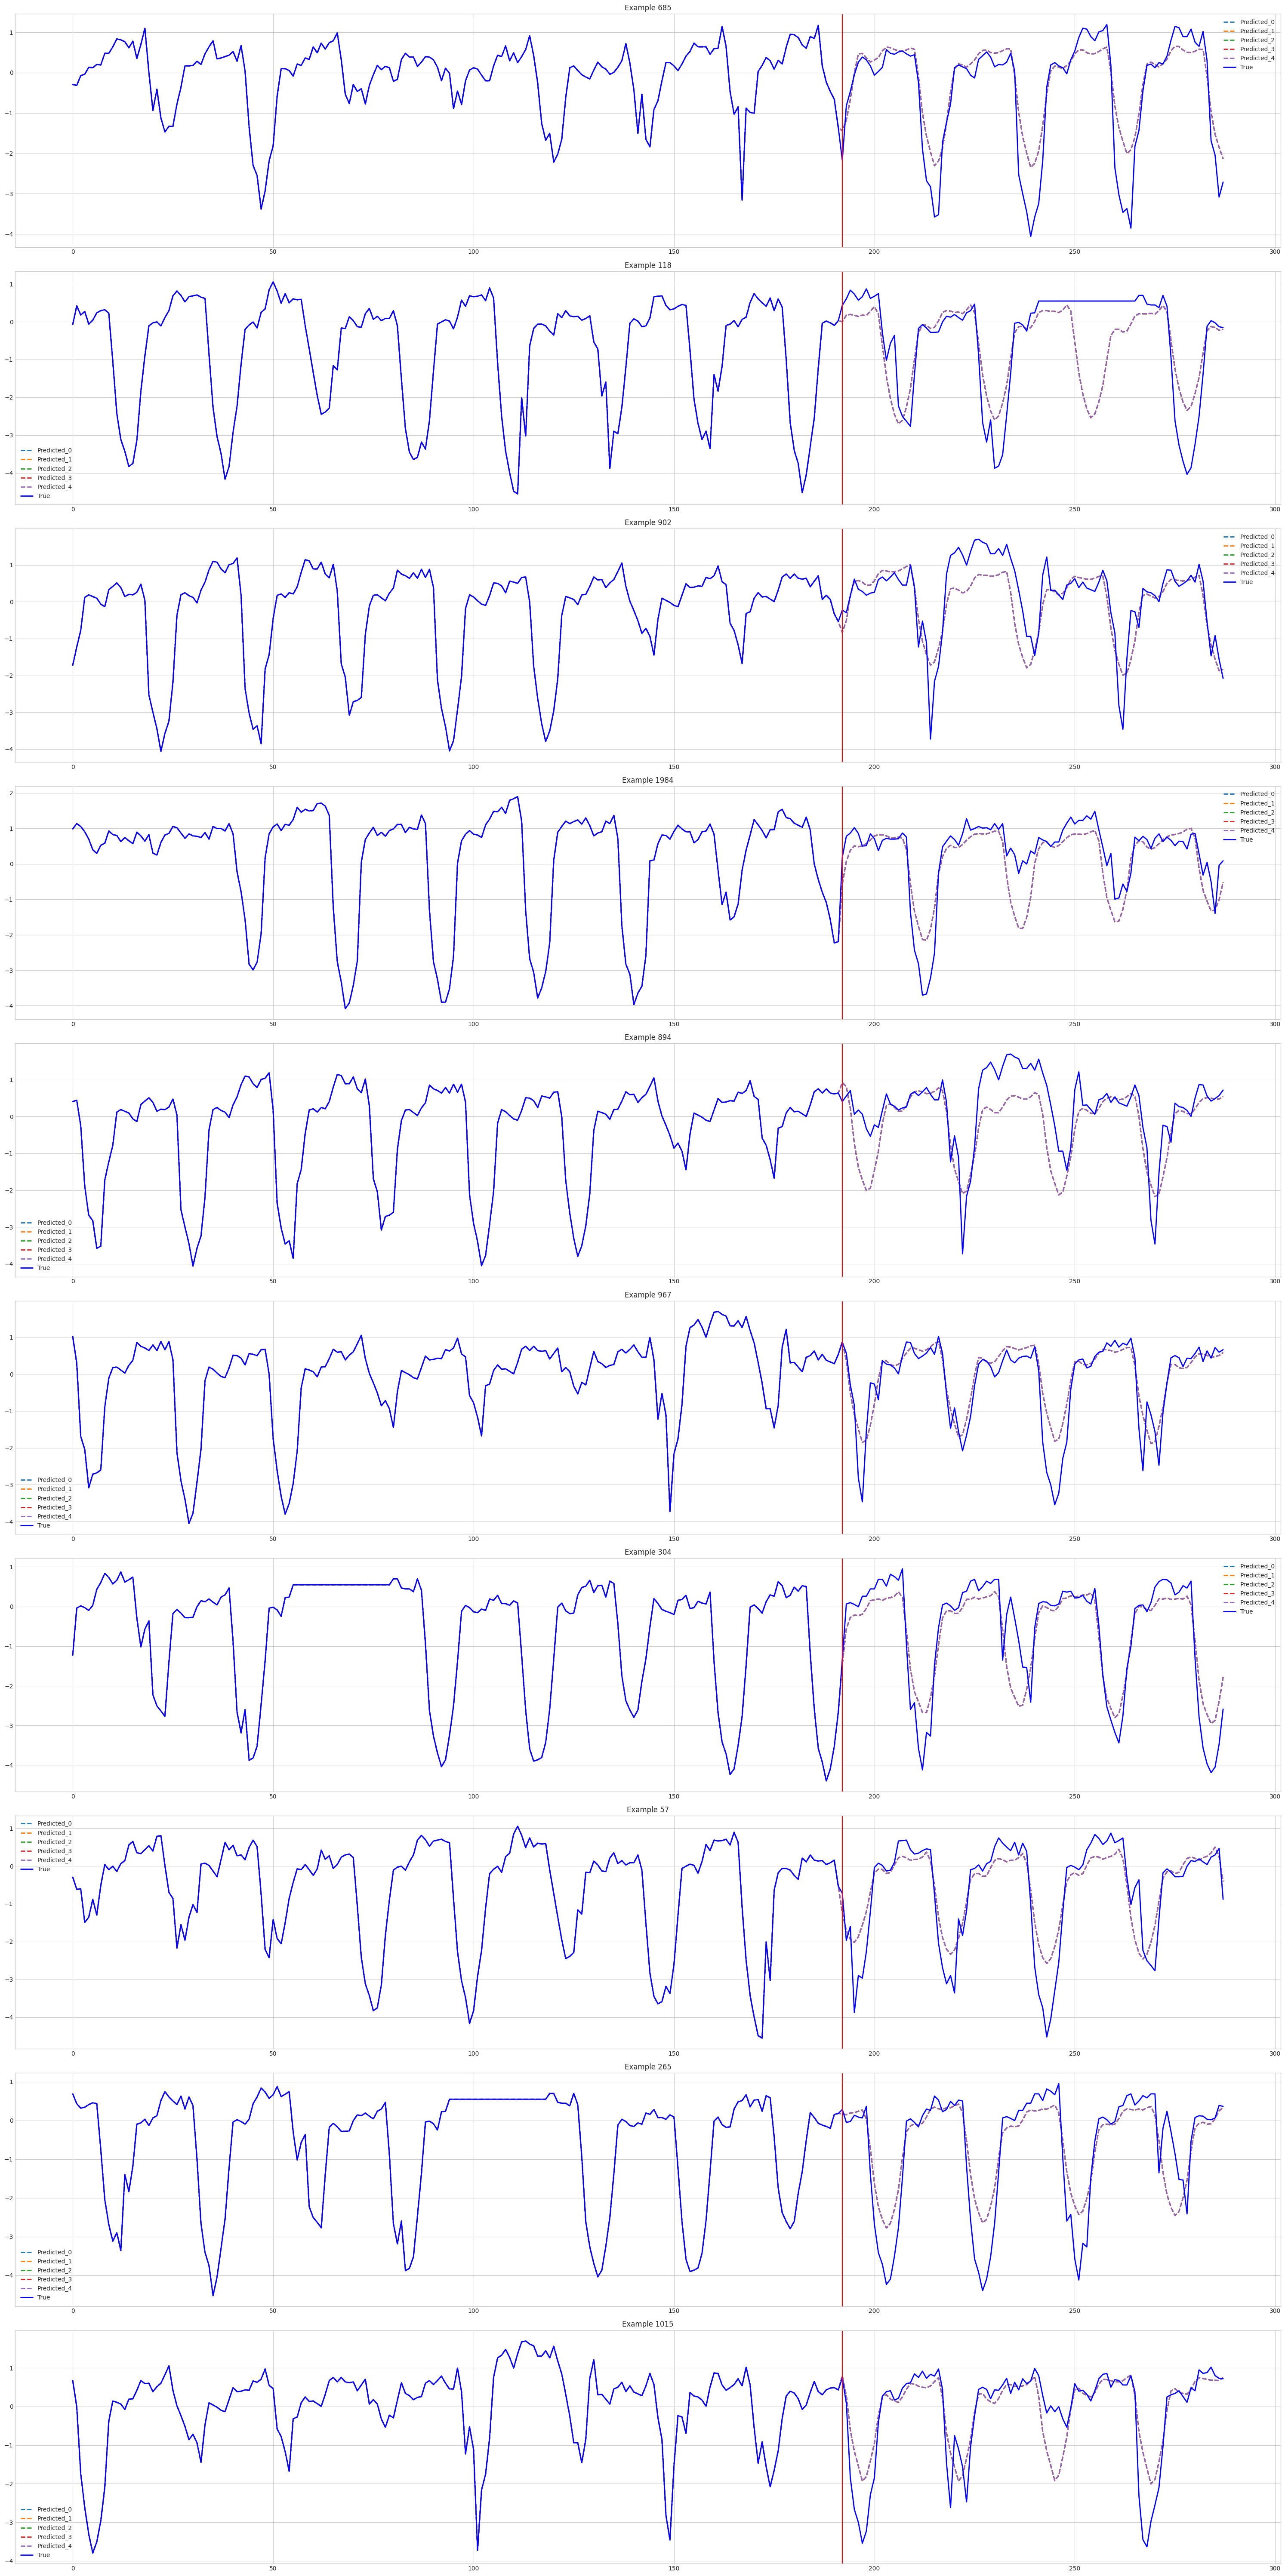

In [13]:
predictions_dict = fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=None,
    loss = "pinball",
    quantile = 0.5,
    multi_quantile_heads=[0.1,0.3,0.5,0.7,0.9],
    multi_quantile_head_weights=[1,1,1,1,1],
    num_epochs=1,
)

In [14]:
preds = predictions_dict.predictions[0]
print(preds.shape)

(2785, 5, 96, 7)


In [23]:
for i in range(5):
    print(preds[0,i,0:10,0])

[ 0.2852316   0.31509072  0.3461929   0.37066418  0.37729067  0.43026078
  0.55171275  0.45777988 -0.17239788 -0.938124  ]
[ 0.2852044   0.31507748  0.34624046  0.37070125  0.37730008  0.43025386
  0.55168575  0.4577561  -0.17242892 -0.9381554 ]
[ 0.28722918  0.31716025  0.34852576  0.37301606  0.37960857  0.43252265
  0.55367994  0.4598868  -0.17061652 -0.93628883]
[ 0.28752828  0.31739765  0.34851748  0.37298787  0.3796116   0.4325779
  0.5540096   0.4600858  -0.1701231  -0.93583566]
[ 0.2875538   0.31741148  0.34850353  0.37297708  0.3796093   0.4325825
  0.5540348   0.4601032  -0.17007934 -0.93580276]


In [19]:
preds[0,4,0:10,0]

array([ 0.2875538 ,  0.31741148,  0.34850353,  0.37297708,  0.3796093 ,
        0.4325825 ,  0.5540348 ,  0.4601032 , -0.17007934, -0.93580276],
      dtype=float32)

### ground_truth = predictions_dict.predictions[-1]

In [12]:
print(ground_truth.shape)

(2785, 96, 7)


In [10]:
print(np.mean((ground_truth - preds[:,0,:,:]) ** 2))

0.36216512
